# Repaso de PCA

El análisis de componentes principales (PCA) es una técnica de transformación lineal simple pero popular y útil que se utiliza en numerosas aplicaciones, como las predicciones del mercado de valores, el análisis de datos de expresión génica y muchas más. En este tutorial, veremos que PCA no es solo una "caja negra", y vamos a desentrañar sus partes internas en 3 pasos básicos.

## Introducción

El gran tamaño de los datos en la era moderna no solo es un desafío para el hardware de la computadora, sino también un cuello de botella principal para el rendimiento de muchos algoritmos de aprendizaje automático. El objetivo principal de PCA es identificar patrones en los datos; PCA tiene como objetivo detectar la correlación entre variables. La reducción de la dimensionalidad tiene sentido si existe una fuerte correlación entre las variables. En pocas palabras, en esto consiste PCA: encontrar las direcciones de máxima varianza en datos de alta dimensión y proyectarlas en un subespacio dimensional más pequeño mientras se retiene la mayor parte de la información.

### PCA Vs. LDA

Tanto el análisis discriminante lineal (LDA) como el PCA son métodos de transformación lineal. PCA produce las direcciones (componentes principales) que maximizan la varianza de los datos, mientras que LDA también tiene como objetivo encontrar las direcciones que maximizan la separación (o discriminación) entre diferentes clases, lo que puede ser útil en problemas de clasificación de patrones (PCA "ignora" la clase etiquetas).
**En otras palabras, PCA proyecta todo el conjunto de datos en un (sub) espacio de características diferente, y LDA intenta determinar un (sub) espacio de características adecuado para distinguir entre patrones que pertenecen a diferentes clases.**

### PCA y reducción de dimensionalidad

Generalmente, un objetivo deseado es reducir las dimensiones de un dataset $d$-dimensional proyectándolo en un subespacio $k$-dimensional (donde $k\;<\;d$) para aumentar la eficiencia computacional mientras se retiene la mayor parte de la información. Una pregunta importante es *¿cuál es el tamaño de $k$ que representa los datos 'bien'?*

Posteriormente, calcularemos los vectores propios (los componentes principales) de un dataset y los recopilaremos en una matriz de proyección. Cada uno de esos autovectores está asociado con un autovalor que puede interpretarse como la "longitud" o "magnitud" del autovector correspondiente. Si algunos valores propios tienen una magnitud significativamente mayor que otros, la reducción del conjunto de datos a través de PCA a un subespacio dimensional más pequeño se puede lograr al eliminar los autovalores/autovectores "menos informativos".

### Un resumen del método de PCA

- Estandarizar los datos.
- Obtener los autovectores y autovalores de la matriz de covarianza o matriz de correlación, o realizar la descomposición de vectores singulares.
- Ordenar los autovalores en orden descendente y escoger los $k$-ésimos autovectores que correspondan a los $k$-ésimos autovalores más grandes, donde $k$ es el número de dimensiones del subespacio de la nueva característica ($k \le d$) /.
- Construir la matriz de proyección $\mathbf{W}$ a partir de los vectores propios de $k$ seleccionados.
- Transformar el conjunto de datos original $\mathbf{X}$ a través de $\mathbf{W}$ para obtener un subespacio de características $k$-dimensional $\mathbf{Y}$.

## Ejemplo con el dataset de Iris

### Cargando el conjunto de datos

In [1]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [2]:
# split data table into data X and class labels y

X = df.iloc[:,0:4].values
y = df.iloc[:,4].values

Nuestro dataset de iris ahora se almacena en forma de una matriz de $150 \times 4$ donde las columnas son las diferentes características y cada fila representa una muestra de flor separada.
Cada fila de muestra $\mathbf{x}$ se puede representar como un vector de 4 dimensiones

$\mathbf{x^T} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix} 
= \begin{pmatrix} \text{sepal length} \\ \text{sepal width} \\\text{petal length} \\ \text{petal width} \end{pmatrix}$

### Visualización exploratoria

Para tener una idea de cómo se distribuyen las 3 clases de flores diferentes a lo largo de las 4 características diferentes, visualicémoslas a través de histogramas.

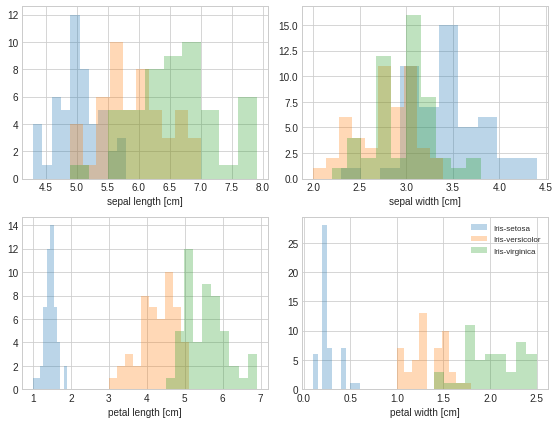

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import math

label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

### Estandarización

La estandarización de los datos antes de un PCA en la matriz de covarianza depende de las escalas de medición de las características originales. Dado que PCA produce un subespacio de características que maximiza la varianza a lo largo de los ejes, tiene sentido estandarizar los datos, especialmente, si se midieron en diferentes escalas. Aunque todas las características del conjunto de datos Iris se midieron en centímetros, continuemos con la transformación de los datos en una escala unitaria (media = 0 y varianza = 1), que es un requisito para el rendimiento óptimo de muchos algoritmos de aprendizaje automático.

In [4]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

## 1 - Descomposición  - Calcular autovalores y autovectores

Los autovectores y autovalores de una matriz de covarianza (o correlación) representan el "núcleo" de PCA: los autovectores (componentes principales) determinan las direcciones del nuevo espacio de características y los autovalores determinan su "magnitud". En otras palabras, los autovalores explican la varianza de los datos a lo largo de los nuevos ejes de características.

### Matriz de covarianza

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a $d \times d$ matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:

$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right).$

We can summarize the calculation of the covariance matrix via the following matrix equation:   
$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$  
where $\mathbf{\bar{x}}$ is the mean vector 
$\mathbf{\bar{x}} = \sum\limits_{i=1}^n x_{i}.$  
The mean vector is a $d$-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.

El enfoque clásico de PCA es realizar la auto-descomposición de la matriz de covarianza $\Sigma$, que es una matriz $d \times d$ donde cada elemento representa la covarianza entre dos características. La covarianza entre dos características se calcula de la siguiente manera:

$$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right).$$

Podemos resumir el cálculo de la matriz de covarianza mediante la siguiente ecuación matricial:
$$\Sigma = \frac{1}{n-1} (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}})$$
donde $\mathbf{\bar{x}}$ es el vector media
$\mathbf{\bar{x}} = \sum\limits_{i=1}^n x_{i}.$
El vector media es un vector $d$-dimensional donde cada valor en este vector representa la media de la muestra de una columna de características en el conjunto de datos.

In [6]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T @ (X_std - mean_vec)/ (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


In [9]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


La forma más detallada de arriba se usó simplemente con fines de demostración, de manera equivalente, podríamos haber usado la función numpy `cov`:

In [9]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


A continuación, realizamos una descomposición propia en la matriz de covarianza:

In [13]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


### Correlation Matrix

Especialmente, en el campo de "Finanzas", la matriz de correlación se usa típicamente en lugar de la matriz de covarianza. Sin embargo, la descomposición propia de la matriz de covarianza (si los datos de entrada estaban estandarizados) arroja los mismos resultados que una descomposición propia en la matriz de correlación, ya que la matriz de correlación puede entenderse como la matriz de covarianza normalizada.

Descomposición propia de los datos estandarizados en base a la matriz de correlación:

In [14]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.91081808 0.92122093 0.14735328 0.02060771]


Descomposición propia de los datos brutos según la matriz de correlación:

In [16]:
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.91081808 0.92122093 0.14735328 0.02060771]


Podemos ver claramente que los tres enfoques producen los mismos vectores propios y pares de valores propios:
    
- Descomposición propia de la matriz de covarianzas después de estandarizar los datos.
- Descomposición propia de la matriz de correlaciones.
- Descomposición propia de la matriz de correlaciones luego de estandarizar los datos.

### Descomposición de vectores singulares (Singular Vector Decomposition)

Si bien la auto-descomposición de la matriz de covarianza o de correlación puede ser más intuitiva, la mayoría de las implementaciones de PCA realizan una [descomposición de vectores singulares (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) para mejorar la eficiencia computacional. Entonces, realicemos una SVD para confirmar que el resultado es el mismo:

In [17]:
u,s,v = np.linalg.svd(X_std.T)
print('Vectors U:\n', u)

Vectors U:
 [[-0.52237162 -0.37231836  0.72101681  0.26199559]
 [ 0.26335492 -0.92555649 -0.24203288 -0.12413481]
 [-0.58125401 -0.02109478 -0.14089226 -0.80115427]
 [-0.56561105 -0.06541577 -0.6338014   0.52354627]]


## 2 - Selección de componentes principales

### Ordenando los pares autovalor-autovector

El objetivo típico de  PCA es reducir la dimensionalidad del espacio de características original proyectándolo en un subespacio más pequeño, donde los vectores propios formarán los ejes. Sin embargo, los autovectores solo definen las direcciones del nuevo eje, ya que todos tienen la misma unidad de longitud 1, lo que se puede confirmar con las siguientes dos líneas de código:

In [18]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


Para decidir qué autovectores pueden eliminarse sin perder demasiada información
para la construcción del subespacio de menor dimensión, necesitamos inspeccionar los valores propios correspondientes: los vectores propios con los valores propios más bajos contienen la menor información sobre la distribución de los datos; esos son los que se pueden dejar caer.
Para hacerlo, el enfoque común es clasificar los autovalores de mayor a menor para elegir los mejores $k$-ésimos autovectores.

In [19]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.9108180837520528
0.9212209307072254
0.1473532783050958
0.020607707235624842


### Varianza explicada

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

Después de clasificar los pares autovalor-autovector, la siguiente pregunta es "¿cuántos componentes principales vamos a elegir para nuestro nuevo subespacio de características?" Una medida útil es la llamada "varianza explicada", que se puede calcular a partir de los autovalores. La varianza explicada nos dice cuánta información (varianza) se puede atribuir a cada uno de los componentes principales.

In [20]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

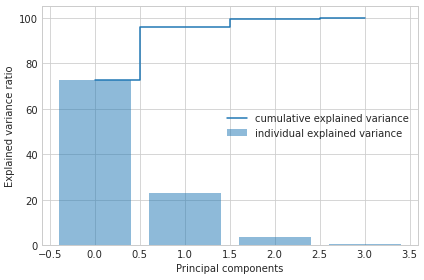

In [21]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

El gráfico anterior muestra claramente que la mayor parte de la varianza (72,77% de la varianza para ser precisos) se puede explicar solo por el primer componente principal. El segundo componente principal todavía contiene algo de información (23,03%), mientras que el tercer y cuarto componentes principales se pueden eliminar de forma segura sin perder mucha información. Juntos, los dos primeros componentes principales contienen el 95,8% de la información.

### Matriz de proyección

Ya es hora de llegar a la parte realmente interesante: la construcción de la matriz de proyección que se utilizará para transformar los datos de Iris en el nuevo subespacio de funciones. Aunque el nombre "matriz de proyección" suena bien, es básicamente una matriz de nuestros $k$ autovectores superiores concatenados.

Aquí, estamos reduciendo el espacio de características de 4 dimensiones a un subespacio de características de 2 dimensiones, eligiendo los "2 mejores" autovectores con los autovalores más altos para construir nuestra matriz $\mathbf{W}$ de autovectores de dimensión $d \times k$.

In [22]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


## 3 - Proyección en el nuevo espacio de características

In this last step we will use the $4 \times 2$-dimensional projection matrix $\mathbf{W}$ to transform our samples onto the new subspace via the equation  
$\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$, where $\mathbf{Y}$ is a $150\times 2$ matrix of our transformed samples.

En este último paso usaremos la matriz de proyección $\mathbf{W}$ de dimensión $4 \times 2$ para transformar nuestras muestras al nuevo subespacio a través de la ecuación
$\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$, donde $\mathbf{Y}$ es una matriz $150\times 2$ de nuestras muestras transformadas.

In [23]:
Y = X_std.dot(matrix_w)

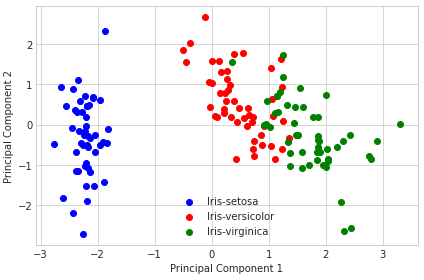

In [24]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()

##  PCA en scikit-learn

Con fines educativos, recorrimos un largo camino para aplicar el PCA al conjunto de datos de Iris. Pero afortunadamente, ya existe una implementación en scikit-learn.

In [25]:
from sklearn.decomposition import PCA 
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

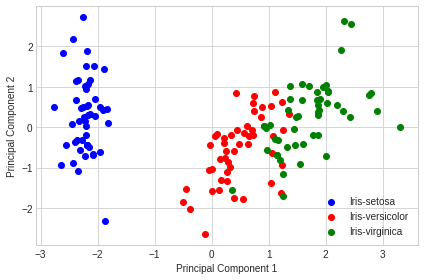

In [27]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()